# Generation of a Time-Series with the simulator for a set of parameters

**Context:**

Provision of a function allowing to test the simulation model with different parameters with visualization with the Matplotlib tool and Plotly with evaluation metrics

## Modules import

First of all we import the dependencies necessary to make the different implementations work.

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yaml
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import sys
sys.path.append("..")
from uvsw_part import simulation
import copy
from math import e
import math
import plotly.graph_objects as go

## Loading paths to List*.txt files 

Here we define the relative paths leading to the different List files. 

In [3]:
LIST_PATH_1 = "../data/params/List1.txt"
LIST_PATH_2 = "../data/params/List2.txt"

## Data coverage rate

We calculate a metric allowing to know the rate of values resulting from simulation included within the reference time-series for each timesteps. <br> We compare the sign of the value from the simulation and the reference for each values, and if they both share the same sign, we compare whether the simulation value has a lower amplitude than the reference one.

In [4]:
def t_couverture (ref,dfy):
    """
    Check if the reference and simulation values have the same sign one by one
     If same sign, appropriate operations to see if the amplitude of the negative or positive simulation
     is well contained in the reference 
    
    Arguments :
    ref (pandas.core.series.Series) (numpy.ndarray) : Reference model 
    dfy (numpy.ndarray)                             : Simplified model generated by the simulator 
    
    
    Sortie :
        Data coverage rate (float): Pourcentage de valeurs de la simulation 
        à l'intérieur de la réference   
    """
    same_sign = 0 # Number of the same sign in reference and simulation (taken 1 by 1)
    
    # Number of times the simulation has the same sign as the reference 
    # AND with the simulation contained in the reference (lower ampltude) 
    
    couverture = 0
    
    
    ref_taille = len(ref) # Total number of values in the reference or the simulation
    
    #Debug
    diff_sign = 0 # Number of times the sign differs between reference and simulation (taken 1 by 1) 
    
    
    for i in range(0,ref_taille):
        if(np.sign(ref[i]) == np.sign(dfy[i])): #If the reference and the sim have the same sign
            same_sign = same_sign + 1


            if(ref[i] < 0): # When the reference < 0  
                if(ref[i] - dfy[i] < 0):# Check if the reference has bigger negative amplitude than the simulation 
                    couverture = couverture + 1
                

            if(ref[i] > 0): # When the reference > 0 
                if(ref[i] - dfy[i] > 0):# Check if the reference has bigger positive amplitude than the simulation 
                    couverture = couverture + 1

            if(ref[i] == 0): # Quand la reference = 0
                if(ref[i] - dfy[i] == 0): # Check if the reference has same amplitude as the simulation
                    couverture = couverture + 1

            if(math.isnan(ref[i]) and math.isnan(dfy[i]) == True): # When the values of the reference and the simulation are both are not available (Na) 
                couverture = couverture + 1             
            
        else :
            diff_sign = diff_sign + 1 # If the reference and the simulation do not have the same sign (debug) 
            

    taux_couverture = (couverture / ref_taille) * 100 # Data coverage rate
    return taux_couverture

## Generation of a Time-Series with the simulator with a set of parameters 

Here, we define the function allowing to launch the simulator with the chosen parameters and to compare the result with the reference model.
Visualizations are made with Matplotlib and Plotly

In [13]:
def generate_ts(u,h,tension,clo,LIST_PATH,TS_INDEX) :
    
    """
    Function using the parameters u, h, tension, cl0 to generate a simulation Time-Series. 
    
    Comparison between the simulation model and the reference model loaded with the 
    desired List file and the Time-Series index 
    
    Arguments : 
        u (float)          : Parameter
        h (float)          : Parameter
        tension (float)    : Parameter
        cl0 (float)        : Parameter
        LIST_PATH (string) : Path to the List file
        TS_INDEX (int)     : Time-Series index to load  (commence à 0) 
    
    Sortie : 
        Graphic visualization of the simplified model and the reference model with Matplotlib
        Graphic visualization of the simplified model and the Plotly reference model 
    
    """

    #Loading the List * .txt file with the path 
    data_list = pd.read_csv(LIST_PATH, delim_whitespace=True)
    
    #Loading of the basic parameters of a Time-Series for the simulation with its index (Index starts at 0) 
    set_params = data_list.iloc[TS_INDEX,:]

    #Loading of the reference Time-Series according to the List file used 
    list_number = LIST_PATH[-9:] # String manipulation to keep only the last portion of the path

    #Retrieve the List file number used and load the desired csv file accordingly
    
    if(list_number == "List1.txt"):
        ref = pd.read_csv("../data/ref/list1/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_1")
        
    if(list_number == "List2.txt"):
        ref = pd.read_csv("../data/ref/list2/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_2")
        
    # If the path does not lead to List 1 or List 2
    if(list_number !=  "List1.txt" and list_number != "List2.txt" ):
        print("Error, List number not supported ")
    
    
    
    
    #Loading of the YAML file containing the list of parameters 
    cfg = yaml.safe_load(open('../data/config/example.in.yaml', 'r'))

    #Loading the parameters to test 
    cfg["cable"]["h"] = float(h)
    cfg["cable"]["tension"] = float(tension)
    cfg["wakeosc"]["u"] = float(u)
    cfg["wakeosc"]["cl0"]= float(clo)

    #Setup of the parameters allowing to produce a simulation of with the same number of points as the reference model
    cfg["simulation"]["tf"] = float(set_params["tf[s]"])
    cfg["simulation"]["dt"] = cfg["simulation"]["tf"] / len(ref) 
    cfg["simulation"]["dr"] = cfg["simulation"]["tf"] / len(ref) 



    print("h Value: ", cfg["cable"]["h"], " u Value: ", cfg["wakeosc"]["u"]," tension Value: ",cfg["cable"]["tension"])
    print("tf Value ", cfg["simulation"]["tf"])
    
    # Launch of the simulator 
    dfy, _ = simulation.run_cable_wakeosc(cfg)
    
    #Metrics calculation 
    mse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    rmse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1],squared = False)
    mea = mean_absolute_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    r2 = r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    taux_couverture = t_couverture(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    
    
    #Storage of metric values in text format for use with the visualization tool
    mse_text= "MSE = %s " % mse
    rmse_text = "RMSE = %s " % rmse
    mea_text = "MEA = %s " % mea
    r2_text = "R2 = %s " % r2
    taux_couverture_text = "Data coverage rate = %s %%" % taux_couverture


    #Visualization with Matplotlib
    plt.figure(figsize = (20,8))
    plt.plot(ref['time'], ref['y/d'], label = "Reference model signal")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "Simulation signal")
    plt.xlabel('Time (s)',fontsize=18)
    plt.ylabel('Signal',fontsize=18)

    #Displaying metrics in the visualization 
    plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.05, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.15, r2_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    #Displaying parameters value and data coverage rate
    plt.figtext(0.5, -0.25, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(cfg['cable']['h'],cfg['cable']['tension'],cfg['wakeosc']['u'],cfg["wakeosc"]["cl0"],cfg["wakeosc"]["eps"]), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.30, taux_couverture_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    #Plot title
    title = "Comparison of the generated simulation signal with the reference signal"
    plt.title(title,fontsize=18)

    plt.legend()
    plt.show() 

    
    # Visualization with Plotly
    fig = go.Figure()
    
    #Reference signal
    fig.add_trace(go.Scatter(x=ref['time'], y=ref['y/d'],
                    name='Reference signal'))
    
    #Simulation signal
    fig.add_trace(go.Scatter(x=dfy.index, y=dfy['s=0.250']/0.025,
                    name='Simulation signal'))
    
    fig.update_layout(
        title="Comparison of the generated simulation signal with the reference signal",
        xaxis_title="Timesteps",
        yaxis_title="Signal",
        legend_title="Signals",
    )

    fig.show()


## Calculation of the simplified model and comparison with the reference model (Matplotlib and Plotly)

The function used here makes it possible to produce the results necessary for the comparison of the simplified model with the parameters chosen with the chosen reference model

Chargement du fichier Liste : Liste_1
h Value:  309.49288554663354  u Value:  0.9535838147886668  tension Value:  11605.8732786244
tf Value  4.0


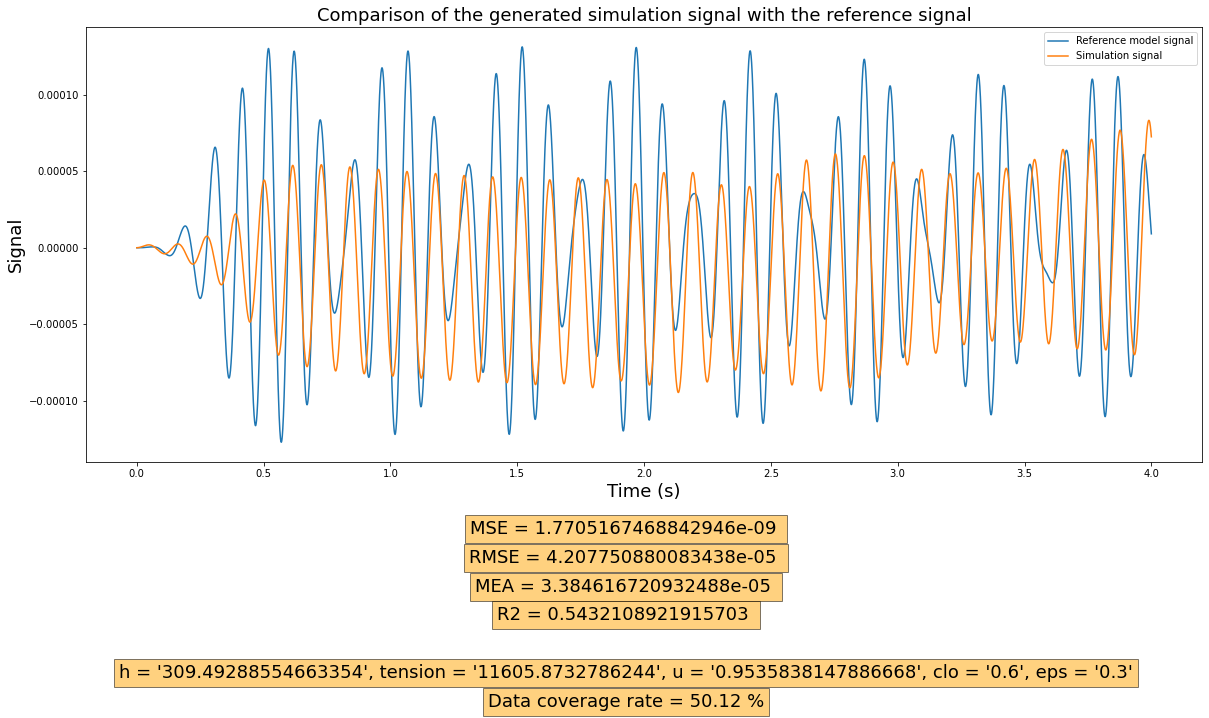

In [14]:
generate_ts(u = 0.9535838147886668,h = 309.49288554663354,
                       tension = 11605.8732786244,clo = 0.6,
                      LIST_PATH  = LIST_PATH_1,TS_INDEX = 5)